# 1) Setup

In [147]:
#libraries
from __future__ import print_function
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sbn
from time import time
import re
from copy import copy
import os
import IPython.display as ipd
import sqlite3

import librosa
import librosa.display
import libfmp.c3
import libtsm
import soundfile
import pydub
import music21

import synctoolbox as stb
from synctoolbox.dtw.mrmsdtw import sync_via_mrmsdtw
from synctoolbox.dtw.utils import compute_optimal_chroma_shift, shift_chroma_vectors, make_path_strictly_monotonic, evaluate_synchronized_positions
from synctoolbox.feature.chroma import pitch_to_chroma, quantize_chroma, quantized_chroma_to_CENS
from synctoolbox.feature.dlnco import pitch_onset_features_to_DLNCO
from synctoolbox.feature.pitch import audio_to_pitch_features
from synctoolbox.feature.pitch_onset import audio_to_pitch_onset_features
from synctoolbox.feature.utils import estimate_tuning

#sklearn
from sklearn.model_selection import train_test_split
import sklearn as skl
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix

#Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

print("done")

done


In [26]:
# custom functions

#perform alignment
from loadfile import *
from extract_chroma import *
from extract_chroma_cens import *
from extract_chroma_onset import *
from extract_features import *
from dtw_path import *
from clip_extract import *

#visualisations
from visualise_path import *
from visualise_path_raw import *
from plot_paths import *

#verification
from verify_frame import *
from verify_frame_check import *
from verify_tsm import *

#utility
from flip_P import *
from xml_to_list import *

#pitch
from start_pitch import *

#tempo
from strict_path import *
from tempo_curve import *
from tempo_curve_smooth import *
from adaptive_window import *
from tempo_curve_adaptive import *
from tempo_curve_adaptive_approx import *
print("done")

done


In [27]:
#music filenames
#naming convention is numbered: piece-extract-version
#e.g. Mendelssohn-slow-musescore is 110
filename110 = "audio/Mendelssohn_musescore_short_slow.mp3"
filename111 = "audio/Mendelssohn_good_short_slow.m4a"
filename112 = "audio/Mendelssohn_errors_short_slow.m4a"
filename120 = "audio/Mendelssohn_musescore_short_fast.mp3"
filename121 = "audio/Mendelssohn_good_short_fast.m4a"
filename122 = "audio/Mendelssohn_errors_short_fast.m4a"

#originals
filename10 = "audio/Mendelssohn_Violin_Concerto.mp3"

#good sounds
fn_gs = "GoodSounds/database.sqlite"
print("done")


done


In [28]:
#params
sr = 22050
n_fft=4410
hop_size=512
spacing = 32
nlines = 30
frame_length = 2048

# 2) Load data
- Sounds: The table containing the sounds annotations.
- takes: A sound can have several takes as some of them were recorded using different microphones at the same time. Each take has an associated audio file.
- packs: A pack is a group of sounds from the same recording session. The audio files are organised in the *sound_files* directory in subfolders with the pack name to which they belong.
- ratings: Some musicians rated some sounds in a 0-10 goodness scale for the user evaluatio of the first project prototype. Please read the paper for more detailed information.

### 2a) Sounds

In [29]:
#many fields are empty, e.g. attach, decay, sustain, release, offset, bridge_velocity, bridge_position, comments( only nans)
con = sqlite3.connect(fn_gs)
df_sounds = pd.read_sql_query("SELECT * from Sounds", con)
df_sounds = df_sounds[df_sounds["instrument"] == "violin"]
df_sounds = df_sounds[["id", 'instrument', 'note', 'octave', 'dynamics', 'string',
       'csv_file', 'csv_id', 'pack_filename', 'pack_id', 'reference', 'klass',
       'semitone', 'pitch_reference']].reset_index(drop=True)
df_sounds

,id,instrument,note,octave,dynamics,string,csv_file,csv_id,pack_filename,pack_id,reference,klass,semitone,pitch_reference
0,1444,violin,G,3.0,mf,4.0,1.0,1,0000.wav,19.0,1,good-sound,43.0,442.0
1,1445,violin,G#,3.0,mf,4.0,1.0,2,0001.wav,19.0,1,good-sound,44.0,442.0
2,1446,violin,A#,3.0,mf,4.0,1.0,3,0002.wav,19.0,1,good-sound,46.0,442.0
3,1447,violin,B,3.0,mf,4.0,1.0,4,0003.wav,19.0,1,good-sound,47.0,442.0
4,1448,violin,A,3.0,mf,4.0,2.0,1,0004.wav,19.0,1,good-sound,45.0,442.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,6515,violin,A,4.0,None,NaN,NaN,-31 render 005,0248.wav,53.0,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0
1379,6516,violin,A,4.0,None,NaN,NaN,-31 render 006,0249.wav,53.0,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0
1380,6517,violin,A,4.0,None,NaN,NaN,-31 render 007,0250.wav,53.0,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0
1381,6518,violin,A,4.0,None,NaN,NaN,-31 render 008,0251.wav,53.0,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0


In [30]:
#fill proportion of the classes
1 -df_sounds.isna().sum()/len(df_sounds)

id                 1.000000
instrument         1.000000
note               1.000000
octave             1.000000
dynamics           0.128706
string             0.339118
csv_file           0.339118
csv_id             1.000000
pack_filename      1.000000
pack_id            1.000000
reference          1.000000
klass              1.000000
semitone           1.000000
pitch_reference    1.000000
dtype: float64

In [31]:
df_sounds["klass"].value_counts()

bad-dynamics                           221
good-sound                             215
bad-richness                            74
bad-timbre                              74
bad-attack                              73
bad-pitch                               72
scale-good-staccato                     50
bad-timbre-errors                       37
bad-richness-bridge                     37
bad-richness-sultasto                   37
bad-attack-pressure                     37
bad-attack-rebond                       37
bad-dynamics-crescendo                  37
bad-dynamics-decrescendo                37
bad-pitch-errors                        36
bad-dynamics-tremolo                    36
bad-pitch-vibrato                       36
bad-dynamics-errors                     34
scale-bad-pitch-staccato                31
scale-bad-rithm-staccato                27
scale-bad-pitch-staccato-minor          25
scale-good-staccato-minor               24
scale-bad-rithm-staccato-minor          24
scale-bad-t

### 2b) takes
- merge this onto using sound_id from takes and id from Sounds
- some recordings are duplicated

In [32]:
#many fields are empty, e.g. attach, decay, sustain, release, offset, bridge_velocity, bridge_position
con = sqlite3.connect(fn_gs)
df_takes = pd.read_sql_query("SELECT * from takes", con)
df_takes = df_takes[df_takes["filename"].str.contains("violin")==True].reset_index(drop=True)
df_takes = df_takes[["microphone","filename","sound_id"]]
df_takes.columns = ["microphone", "filename", "id"]
df_takes

,microphone,filename,id
0,akg,sound_files/violin_raquel_reference/akg/0000.wav,1444
1,neumann,sound_files/violin_raquel_reference/neumann/00...,1444
2,akg,sound_files/violin_raquel_reference/akg/0001.wav,1445
3,neumann,sound_files/violin_raquel_reference/neumann/00...,1445
4,akg,sound_files/violin_raquel_reference/akg/0002.wav,1446
...,...,...,...
1847,neumann,sound_files/violin_violin_scales_laia_recordin...,6515
1848,neumann,sound_files/violin_violin_scales_laia_recordin...,6516
1849,neumann,sound_files/violin_violin_scales_laia_recordin...,6517
1850,neumann,sound_files/violin_violin_scales_laia_recordin...,6518


## 2c) packs
- shows the purpose of the packs
- map the id onto the pack_id

In [33]:
#many fields are empty, e.g. attach, decay, sustain, release, offset, bridge_velocity, bridge_position
con = sqlite3.connect(fn_gs)
df_packs = pd.read_sql_query("SELECT * from packs", con)
df_packs = df_packs[df_packs["name"].str.contains("violin")==True].reset_index(drop=True)
df_packs.columns = ["pack_id", "pack_name", "pack_description"]
df_packs

,pack_id,pack_name,pack_description
0,19,violin_raquel_reference,Play reference notes
1,21,violin_raquel_dynamics_stability,Notes to study dynamics stability
2,27,violin_raquel_pitch_stability,Notes to measure pitch stability
3,28,violin_raquel_timbre_stability,Notes to measure timbre stability
4,29,violin_raquel_richness,Notes to measure timbre richness
5,30,violin_raquel_attack,Notes to measure attack clarity
6,43,violin_laia_improvement_recordings,Recordings to improve models
7,44,violin_laia_improvement_recordings_2,Recordings to improve models
8,53,violin_violin_scales_laia_recordings,Violin recordings of scales


## 2d) ratings
- partial data. Not very useful in the context of my 3yp

In [34]:
#many fields are empty, e.g. attach, decay, sustain, release, offset, bridge_velocity, bridge_position
con = sqlite3.connect(fn_gs)
df_ratings = pd.read_sql_query("SELECT * from ratings", con)
df_ratings

,id,mark,type,created_at,comments,sound_id,rater
0,1,7.0,good-sound,2013-12-02 15:00:00.000000,cause of dynamics & attack,234,margarita
1,2,6.0,attack,2013-12-02 15:00:00.000000,cause of dynamics & attack,234,margarita
2,3,8.0,stability,2013-12-02 15:00:00.000000,cause of dynamics & attack,234,margarita
3,4,8.0,release,2013-12-02 15:00:00.000000,cause of dynamics & attack,234,margarita
4,5,7.0,good-sound,2013-12-02 15:00:00.000000,"cause of dynamics & attack, but it is richer (...",235,margarita
...,...,...,...,...,...,...,...
1398,1399,7.0,good-sound,2015-03-31 15:00:00.000000,,4326,oriol
1399,1400,4.0,good-sound,2015-03-31 15:00:00.000000,,4384,oriol
1400,1401,3.0,good-sound,2015-03-31 15:00:00.000000,,2634,oriol
1401,1402,4.0,good-sound,2015-03-31 15:00:00.000000,,2729,oriol


## 2e) Data merging
- merge takes onto sounds to get all recordings
- merge pack onto sounds according to id, pack_id, respectively


In [35]:
df_merge = copy(df_sounds)
df_merge = df_merge.merge(df_takes, on = "id", how = "outer") #multiple copies
df_merge = df_merge.merge(df_packs, on = "pack_id", how = "outer")
df_merge.to_pickle("df_goodsounds.pkl")
df_merge

,id,instrument,note,octave,dynamics,string,csv_file,csv_id,pack_filename,pack_id,reference,klass,semitone,pitch_reference,microphone,filename,pack_name,pack_description
0,1444,violin,G,3.0,mf,4.0,1.0,1,0000.wav,19.0,1,good-sound,43.0,442.0,akg,sound_files/violin_raquel_reference/akg/0000.wav,violin_raquel_reference,Play reference notes
1,1444,violin,G,3.0,mf,4.0,1.0,1,0000.wav,19.0,1,good-sound,43.0,442.0,neumann,sound_files/violin_raquel_reference/neumann/00...,violin_raquel_reference,Play reference notes
2,1445,violin,G#,3.0,mf,4.0,1.0,2,0001.wav,19.0,1,good-sound,44.0,442.0,akg,sound_files/violin_raquel_reference/akg/0001.wav,violin_raquel_reference,Play reference notes
3,1445,violin,G#,3.0,mf,4.0,1.0,2,0001.wav,19.0,1,good-sound,44.0,442.0,neumann,sound_files/violin_raquel_reference/neumann/00...,violin_raquel_reference,Play reference notes
4,1446,violin,A#,3.0,mf,4.0,1.0,3,0002.wav,19.0,1,good-sound,46.0,442.0,akg,sound_files/violin_raquel_reference/akg/0002.wav,violin_raquel_reference,Play reference notes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,6515,violin,A,4.0,None,NaN,NaN,-31 render 005,0248.wav,53.0,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,sound_files/violin_violin_scales_laia_recordin...,violin_violin_scales_laia_recordings,Violin recordings of scales
1848,6516,violin,A,4.0,None,NaN,NaN,-31 render 006,0249.wav,53.0,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,sound_files/violin_violin_scales_laia_recordin...,violin_violin_scales_laia_recordings,Violin recordings of scales
1849,6517,violin,A,4.0,None,NaN,NaN,-31 render 007,0250.wav,53.0,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,sound_files/violin_violin_scales_laia_recordin...,violin_violin_scales_laia_recordings,Violin recordings of scales
1850,6518,violin,A,4.0,None,NaN,NaN,-31 render 008,0251.wav,53.0,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,sound_files/violin_violin_scales_laia_recordin...,violin_violin_scales_laia_recordings,Violin recordings of scales


## 2f) data formatting
- id, instrument, csv_file & csv_id are now redundant
- alter klass into 6 classes
- alter filename into the correct path
- remove reference if all 1s - this is not the case. 864/1852 are not used to train good sounds models. Not sure why not!

In [36]:
df_merge = df_merge[["note", "octave", "dynamics", "string", "reference", "klass", "semitone", "pitch_reference", "microphone", "filename", "pack_filename", "pack_name", "pack_description"]]
df_merge['filename'] = df_merge['filename'].str.replace('sound_files/','GoodSounds/')
df_merge["class"] = df_merge["klass"]
df_merge

C:\Users\pyliu\AppData\Local\Temp/ipykernel_139588/1932253375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['filename'] = df_merge['filename'].str.replace('sound_files/','GoodSounds/')
C:\Users\pyliu\AppData\Local\Temp/ipykernel_139588/1932253375.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge["class"] = df_merge["klass"]


,note,octave,dynamics,string,reference,klass,semitone,pitch_reference,microphone,filename,pack_filename,pack_name,pack_description,class
0,G,3.0,mf,4.0,1,good-sound,43.0,442.0,akg,GoodSounds/violin_raquel_reference/akg/0000.wav,0000.wav,violin_raquel_reference,Play reference notes,good-sound
1,G,3.0,mf,4.0,1,good-sound,43.0,442.0,neumann,GoodSounds/violin_raquel_reference/neumann/000...,0000.wav,violin_raquel_reference,Play reference notes,good-sound
2,G#,3.0,mf,4.0,1,good-sound,44.0,442.0,akg,GoodSounds/violin_raquel_reference/akg/0001.wav,0001.wav,violin_raquel_reference,Play reference notes,good-sound
3,G#,3.0,mf,4.0,1,good-sound,44.0,442.0,neumann,GoodSounds/violin_raquel_reference/neumann/000...,0001.wav,violin_raquel_reference,Play reference notes,good-sound
4,A#,3.0,mf,4.0,1,good-sound,46.0,442.0,akg,GoodSounds/violin_raquel_reference/akg/0002.wav,0002.wav,violin_raquel_reference,Play reference notes,good-sound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,A,4.0,None,NaN,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,GoodSounds/violin_violin_scales_laia_recording...,0248.wav,violin_violin_scales_laia_recordings,Violin recordings of scales,scale-bad-pitch-dirt-staccato-minor
1848,A,4.0,None,NaN,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,GoodSounds/violin_violin_scales_laia_recording...,0249.wav,violin_violin_scales_laia_recordings,Violin recordings of scales,scale-bad-pitch-dirt-staccato-minor
1849,A,4.0,None,NaN,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,GoodSounds/violin_violin_scales_laia_recording...,0250.wav,violin_violin_scales_laia_recordings,Violin recordings of scales,scale-bad-pitch-dirt-staccato-minor
1850,A,4.0,None,NaN,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,GoodSounds/violin_violin_scales_laia_recording...,0251.wav,violin_violin_scales_laia_recordings,Violin recordings of scales,scale-bad-pitch-dirt-staccato-minor


In [37]:
df_merge["klass"].value_counts()

good-sound                             283
bad-dynamics                           221
bad-richness-bridge                     74
bad-richness                            74
bad-dynamics-crescendo                  74
bad-attack-rebond                       74
bad-attack-pressure                     74
bad-richness-sultasto                   74
bad-timbre                              74
bad-timbre-errors                       74
bad-dynamics-decrescendo                74
bad-attack                              73
bad-pitch-errors                        72
bad-pitch-vibrato                       72
bad-pitch                               72
bad-dynamics-tremolo                    72
bad-dynamics-errors                     68
scale-good-staccato                     50
scale-bad-pitch-staccato                31
scale-bad-rithm-staccato                27
scale-bad-pitch-staccato-minor          25
scale-good-staccato-minor               24
scale-bad-rithm-staccato-minor          24
scale-bad-t

In [38]:
df_merge['class'] = df_merge['class'].str.replace('-bridge','')
df_merge['class'] = df_merge['class'].str.replace('-crescendo','')
df_merge['class'] = df_merge['class'].str.replace('-rebond','')
df_merge['class'] = df_merge['class'].str.replace('-pressure','')
df_merge['class'] = df_merge['class'].str.replace('-sultasto','')
df_merge['class'] = df_merge['class'].str.replace('-errors','')
df_merge['class'] = df_merge['class'].str.replace('-decrescendo','')
df_merge['class'] = df_merge['class'].str.replace('-vibrato','')
df_merge['class'] = df_merge['class'].str.replace('-tremolo','')
df_merge['class'] = df_merge['class'].str.replace('-staccato','')
df_merge['class'] = df_merge['class'].str.replace('-minor','')
df_merge['class'] = df_merge['class'].str.replace('-dirt','')
df_merge['class'] = df_merge['class'].str.replace('scale-','')
df_merge['class'] = df_merge['class'].str.replace('-sound','')
df_merge['class'] = df_merge['class'].str.replace('-rithm','-rhythm')
df_merge["class"].value_counts()

C:\Users\pyliu\AppData\Local\Temp/ipykernel_139588/2746269643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['class'] = df_merge['class'].str.replace('-bridge','')
C:\Users\pyliu\AppData\Local\Temp/ipykernel_139588/2746269643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['class'] = df_merge['class'].str.replace('-crescendo','')
C:\Users\pyliu\AppData\Local\Temp/ipykernel_139588/2746269643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

bad-dynamics    509
good            357
bad-pitch       297
bad-attack      244
bad-richness    222
bad-timbre      172
bad-rhythm       51
Name: class, dtype: int64

In [44]:
#one-hot_encode
classes = {"good": 0, "bad-dynamics":1, "bad-pitch":2, "bad-timbre":3, "bad-richness":4, "bad-attack":5, "bad-rhythm":6}
df_merge["class_num"] = df_merge["class"].replace(to_replace = classes)
#add a filter to remove scales
df_merge["scale"] = df_merge['klass'].str.contains("scale")
df_merge.to_pickle("df_goodsounds.pkl")
df_merge.to_csv("df_goodsounds.csv")
df_merge

C:\Users\pyliu\AppData\Local\Temp/ipykernel_139588/278886184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge["class_num"] = df_merge["class"].replace(to_replace = classes)
C:\Users\pyliu\AppData\Local\Temp/ipykernel_139588/278886184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge["scale"] = df_merge['klass'].str.contains("scale")


,note,octave,dynamics,string,reference,klass,semitone,pitch_reference,microphone,filename,pack_filename,pack_name,pack_description,class,class_num,scale
0,G,3.0,mf,4.0,1,good-sound,43.0,442.0,akg,GoodSounds/violin_raquel_reference/akg/0000.wav,0000.wav,violin_raquel_reference,Play reference notes,good,0,False
1,G,3.0,mf,4.0,1,good-sound,43.0,442.0,neumann,GoodSounds/violin_raquel_reference/neumann/000...,0000.wav,violin_raquel_reference,Play reference notes,good,0,False
2,G#,3.0,mf,4.0,1,good-sound,44.0,442.0,akg,GoodSounds/violin_raquel_reference/akg/0001.wav,0001.wav,violin_raquel_reference,Play reference notes,good,0,False
3,G#,3.0,mf,4.0,1,good-sound,44.0,442.0,neumann,GoodSounds/violin_raquel_reference/neumann/000...,0001.wav,violin_raquel_reference,Play reference notes,good,0,False
4,A#,3.0,mf,4.0,1,good-sound,46.0,442.0,akg,GoodSounds/violin_raquel_reference/akg/0002.wav,0002.wav,violin_raquel_reference,Play reference notes,good,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,A,4.0,None,NaN,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,GoodSounds/violin_violin_scales_laia_recording...,0248.wav,violin_violin_scales_laia_recordings,Violin recordings of scales,bad-pitch,2,True
1848,A,4.0,None,NaN,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,GoodSounds/violin_violin_scales_laia_recording...,0249.wav,violin_violin_scales_laia_recordings,Violin recordings of scales,bad-pitch,2,True
1849,A,4.0,None,NaN,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,GoodSounds/violin_violin_scales_laia_recording...,0250.wav,violin_violin_scales_laia_recordings,Violin recordings of scales,bad-pitch,2,True
1850,A,4.0,None,NaN,1,scale-bad-pitch-dirt-staccato-minor,57.0,442.0,neumann,GoodSounds/violin_violin_scales_laia_recording...,0251.wav,violin_violin_scales_laia_recordings,Violin recordings of scales,bad-pitch,2,True


# 3) Extract features
- there are 1852 files to extract. This might take significant time
- extract frame-based features
- Use essentia ==> I'll do this on Colab since I run windows on personal laptop

The second part of this is to segment a recording by note onsets, and convert each "note" into a row in the test dataframe

If the current features do not work well, I should find some way to incorporate pitch & tristimulus into the features
- I.e. also calculate & extract those features

## 3b) Scale features to approx 0-1

In [65]:
df_features = pd.read_pickle("df_features.pkl")
df_features.columns = df_features.columns.str.replace('lowlevel.','')
df_features


C:\Users\pyliu\AppData\Local\Temp/ipykernel_139588/3688872628.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_features.columns = df_features.columns.str.replace('lowlevel.','')


,pred_target,semitone,average_loudness,dissonance.mean,dissonance.stdev,dynamic_complexity,hfc.mean,hfc.stdev,pitch_salience.mean,pitch_salience.stdev,...,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
0,0,43.0,0.973898,0.328016,0.081088,6.571340,21.573214,12.731994,0.512181,0.168642,...,937.056824,411.498627,3.215111,2.526250,2600707.25,1731604.250,2.017176,1.059170,0.025192,0.009698
1,0,43.0,0.970834,0.368570,0.086096,6.664230,22.945324,13.807193,0.439148,0.135091,...,1245.576904,596.640808,2.655115,2.509936,2574120.75,1505413.625,2.009374,1.051281,0.034124,0.014582
2,0,44.0,0.970306,0.330389,0.072180,9.287111,14.885549,8.775313,0.231910,0.125206,...,394.896851,231.863678,3.113860,1.137637,3334733.50,3271542.750,2.541871,1.389828,0.017051,0.007408
3,0,44.0,0.971340,0.375422,0.060669,9.415653,17.328463,10.013210,0.237998,0.120581,...,476.376190,359.827148,2.502605,0.945895,3185106.25,2859485.500,2.436985,1.321043,0.020622,0.011249
4,0,46.0,0.976993,0.373389,0.066770,2.779667,34.625576,16.528374,0.731040,0.169148,...,1236.328979,389.756622,2.354097,1.426084,2546465.00,1912766.875,2.739003,1.085537,0.049303,0.016021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,5,75.0,0.920788,0.483842,0.025960,11.983217,6.973180,16.168629,0.678351,0.105374,...,6857.688965,4776.493164,1.939465,0.429926,5021553.00,2165782.750,2.492158,3.476444,0.199842,0.093627
1595,5,76.0,0.934111,0.463875,0.046839,8.940342,21.887594,39.403152,0.505550,0.156219,...,4088.420166,3990.791992,2.529024,0.687118,4638064.00,2118275.250,4.141496,3.678046,0.147577,0.075532
1596,5,77.0,0.938575,0.483767,0.031232,7.934243,19.836596,34.396435,0.533595,0.137526,...,5300.651367,4198.982422,1.901967,0.346736,4977651.50,1862666.125,2.819529,2.516868,0.149958,0.081871
1597,5,78.0,0.938716,0.484582,0.050698,11.783878,12.083974,26.380951,0.537743,0.167353,...,6176.474609,3982.024170,2.109447,0.550107,4810459.50,2873182.250,3.890090,4.322021,0.176928,0.078975


In [66]:
#divide by magnitude of max value
scaling = 10**np.floor(np.log(np.abs(df_features.max())))
print(scaling)
#df_scaled = df_features.divide(scaling, axis=1 )
#df_scaled

pred_target                              1.000000e+01
semitone                                 1.000000e+04
average_loudness                         1.000000e-01
dissonance.mean                          1.000000e-01
dissonance.stdev                         1.000000e-02
dynamic_complexity                       1.000000e+03
hfc.mean                                 1.000000e+04
hfc.stdev                                1.000000e+04
pitch_salience.mean                      1.000000e-01
pitch_salience.stdev                     1.000000e-02
spectral_centroid.mean                   1.000000e+08
spectral_centroid.stdev                  1.000000e+07
spectral_complexity.mean                 1.000000e+02
spectral_complexity.stdev                1.000000e+02
spectral_decrease.mean                   1.000000e-22
spectral_decrease.stdev                  1.000000e-19
spectral_energy.mean                     1.000000e-04
spectral_energy.stdev                    1.000000e-04
spectral_energyband_high.mea

In [79]:
df_scaled = copy(df_features)
df_scaled["spectral_centroid.mean"] = df_scaled["spectral_centroid.mean"] /1000
df_scaled["spectral_centroid.stdev"] = df_scaled["spectral_centroid.stdev"] /1000
df_scaled["spectral_decrease.mean"] = df_scaled["spectral_decrease.mean"] *1000000
df_scaled["spectral_decrease.stdev"] = df_scaled["spectral_decrease.stdev"] *1000000
df_scaled["spectral_rolloff.mean"] = df_scaled["spectral_rolloff.mean"] /1000
df_scaled["spectral_rolloff.stdev"] = df_scaled["spectral_rolloff.stdev"] /1000
df_scaled["spectral_spread.mean"] = df_scaled["spectral_spread.mean"] /1000000
df_scaled["spectral_spread.stdev"] = df_scaled["spectral_spread.stdev"] /1000000

df_scaled["dynamic_complexity"] = df_scaled["dynamic_complexity"] /100
df_scaled["semitone"] = df_scaled["semitone"] /100
df_scaled["hfc.mean"] = df_scaled["hfc.mean"] /100
df_scaled["hfc.stdev"] = df_scaled["hfc.stdev"] /100
df_scaled["spectral_complexity.mean"] = df_scaled["spectral_complexity.mean"] /10
df_scaled["spectral_complexity.stdev"] = df_scaled["spectral_complexity.stdev"] /10
df_scaled["spectral_kurtosis.mean"] = df_scaled["spectral_kurtosis.mean"] /100
df_scaled["spectral_kurtosis.stdev"] = df_scaled["spectral_kurtosis.stdev"] /100
df_scaled["spectral_strongpeak.mean"] = df_scaled["spectral_strongpeak.mean"] /10
df_scaled["spectral_strongpeak.stdev"] = df_scaled["spectral_strongpeak.stdev"] /10

df_scaled.max()

pred_target                              5.000000
semitone                                 0.790000
average_loudness                         0.990684
dissonance.mean                          0.493970
dissonance.stdev                         0.155416
dynamic_complexity                       0.267026
hfc.mean                                 0.730393
hfc.stdev                                0.863184
pitch_salience.mean                      0.761743
pitch_salience.stdev                     0.357466
spectral_centroid.mean                   3.771363
spectral_centroid.stdev                  1.289493
spectral_complexity.mean                 1.810366
spectral_complexity.stdev                1.505908
spectral_decrease.mean                  -0.000391
spectral_decrease.stdev                  0.006531
spectral_energy.mean                     0.035606
spectral_energy.stdev                    0.026878
spectral_energyband_high.mean            0.010334
spectral_energyband_high.stdev           0.012779


# 4) Train classifier

In [96]:
def get_TrainTest(df_scaled,test_size = 0.3, seed = 0):
    """
    Get Train & Test matrices in correct format
    """
    label = "pred_target"
    features = df_scaled.columns[1:]

    # Split data 70%-30% into training set and test set
    x_train, x_test, y_train, y_test = train_test_split(df_scaled[features].values,
                                                        df_scaled[label].values,
                                                        test_size=test_size,
                                                        random_state=seed)

    print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))

    #set data types
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train = utils.to_categorical(y_train)
    y_test = utils.to_categorical(y_test) 
    
    return x_train, y_train, x_test, y_test

In [103]:
def create_NN(hidden, dropout, input_dim, is_regression = True, std =  0.01, seed = 1):
    """
    Create MLP regression / classifier with random initialisation, Batch Normalisation & dropout
    """
    if len(hidden) != len(dropout):
        raise ValueError("Incompatible sequence lengths for hidden & dropout")
    model = Sequential()
    #input layer
    model.add(Dense(hidden[0], input_dim=input_dim, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    #hidden layers
    for i in range(1,len(hidden)):
        model.add(Dense(hidden[i], input_dim=hidden[i-1], activation='relu',kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[i]))
    #output layer
    if is_regression:
        model.add(Dense(1, input_dim=hidden[-1], activation=None,kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    else:
        model.add(Dense(6, input_dim=hidden[-1], activation="softmax",kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    return model
    

In [104]:
def train_NN(model, x_train, y_train, x_test, y_test, learning_rate = 0.1, is_regression = True, num_epochs = 50, plot_graph = False):
    """
    Train NN with Adam optimiser
    """
    #create optimiser
    opt = optimizers.Adam(learning_rate=learning_rate)
    if is_regression:
        loss_fn = keras.losses.MeanSquaredError()
    else:
        loss_fn = keras.losses.CategoricalCrossentropy()
    model.compile(loss=loss_fn,
                  optimizer=opt,
                  metrics=[loss_fn])
    #fit model
    history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=500, validation_data=(x_test, y_test), verbose = 0)

    #plot fitting results
    if plot_graph:
        epoch_nums = range(1,num_epochs+1)
        training_loss = history.history["loss"]
        validation_loss = history.history["val_loss"]
        plt.plot(epoch_nums, training_loss)
        plt.plot(epoch_nums, validation_loss)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['training', 'validation'], loc='upper right')
        plt.show()
    
    return model, history

In [144]:
#set seed
np.random.seed(1)
tf.random.set_seed(1)
seed = 1

#model params
hidden = [100,100]
dropout = [0.1,0.1]
is_regression = False
learning_rate = 0.0001
num_epochs = 2000

In [175]:
x_train, y_train, x_test, y_test = get_TrainTest(df_scaled,test_size = 0.3, seed = seed)
print("x_train shape:", x_train.shape)
print("y_train shape:",y_train.shape)
print("x_test shape:",x_test.shape)
print("y_test shape:",y_test.shape)

Training Set: 1119, Test Set: 480 

x_train shape: (1119, 43)
y_train shape: (1119, 6)
x_test shape: (480, 43)
y_test shape: (480, 6)


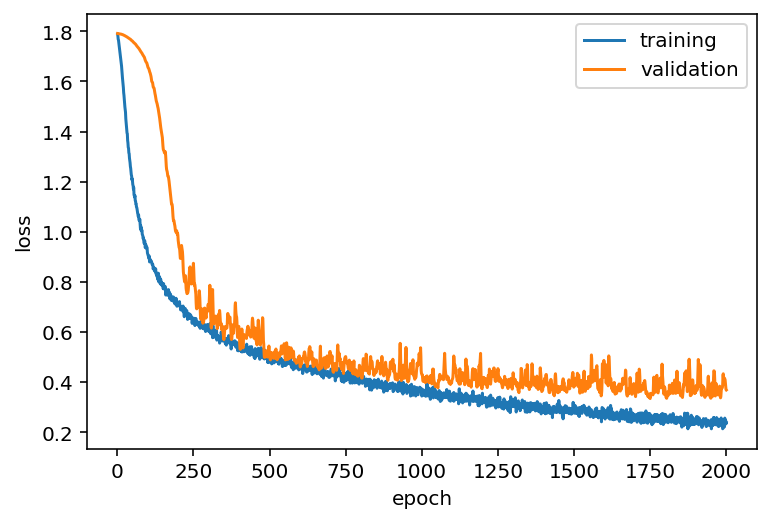

In [145]:
#create model & train
model = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(model.summary())
model, history = train_NN(model, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

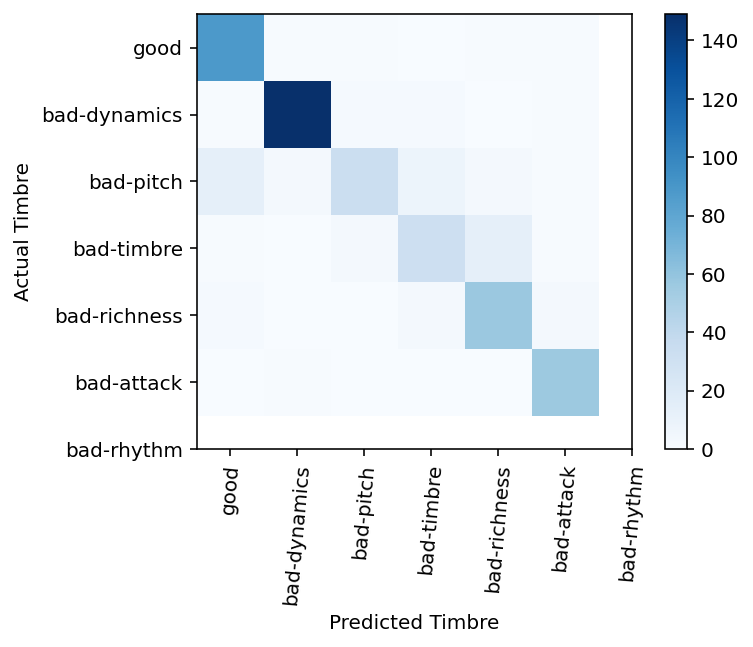

In [162]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
class_probabilities = model.predict(x_test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)
timbre_classes = ["good", "bad-dynamics", "bad-pitch", "bad-timbre", "bad-richness", "bad-attack", "bad-rhythm"]

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(timbre_classes))
plt.xticks(tick_marks, timbre_classes, rotation=85)
plt.yticks(tick_marks, timbre_classes)
plt.xlabel("Predicted Timbre")
plt.ylabel("Actual Timbre")
plt.show()

In [176]:
print(cm)

[[ 88   1   1   0   1   1]
 [  1 149   2   2   0   1]
 [ 13   3  33   8   3   1]
 [  1   0   3  32  13   1]
 [  2   0   0   3  57   3]
 [  0   1   0   0   0  56]]


In [180]:
for i in range(len(cm)):
    rowsum = sum(cm[i])
    diag = cm[i][i]
    print("fp for class",i,":",(rowsum-diag), "/", rowsum, "=", (rowsum-diag)/rowsum)

fp for class 0 : 4 / 92 = 0.043478260869565216
fp for class 1 : 6 / 155 = 0.03870967741935484
fp for class 2 : 28 / 61 = 0.45901639344262296
fp for class 3 : 18 / 50 = 0.36
fp for class 4 : 8 / 65 = 0.12307692307692308
fp for class 5 : 1 / 57 = 0.017543859649122806


In [166]:
#accuracy
print(skl.metrics.accuracy_score(true_labels, predictions, normalize=True, sample_weight=None))
print(skl.metrics.roc_auc_score(y_test, class_probabilities, multi_class = "ovr"))

0.8645833333333334
0.9827066350598209


In [173]:
#percentage of good sounds that are labelled as good
sum(predictions[true_labels == 0] == 0)/len(predictions[true_labels == 0]) * 100

95.65217391304348

In [164]:
# Save the trained model
modelFileName = 'models/timbre-classifier.h5'
model.save(modelFileName)
print('model saved as', modelFileName)
#model = models.load_model(modelFileName)

model saved as models/timbre-classifier.h5
